In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e18/sample_submission.csv
/kaggle/input/playground-series-s3e18/train.csv
/kaggle/input/playground-series-s3e18/test.csv


In [58]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from scipy.cluster import hierarchy

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import uniform

from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc

### <font color='289C4E'>Table of contents<font><a class='anchor' id='top'></a>
- [Data Analysis](#1)
- [Feature Analysis](#2)
- [Model and Hyperparameter Selection](#3)
- [Model Analysis](#4)
- [Final Submission](#5)

**Abstract**

The enzyme dataset is a multi-label classification problem consisting of predicting EC1 and EC2 with the values 0 and 1. 

As part of data analysis, we perform checks for duplicates, distribution, outliers, and class imbalance. There is a major class imbalance for the EC2 label with ~20-80% and a slightly imbalanced EC1 with ~30-70%. Therefore, we resampled the data by oversampling and undersampling, and we observed that oversampling provides more data for the training of the models and assists in a higher F1 score. There were no point outliers or duplicates found.

As part of the feature analysis, we performed Pearson correlation, single linkage dendrogram, feature Importance score, Recursive Feature Elimination, variance analysis, PCA variance, and loading plot analysis. Pearson correlation, dendrograms, and PCA loading plots to find similar or exact features. If two or more features are similar, we perform a Feature Importance score using random forest and variance analysis to identify which feature assists the model to learn and we drop other features. We selected 11 and 7 features for EC1 and EC2 classification respectively.

As part of Model and Hyperparameter Selection, we use the classifiers - Logistic, Ridge, SVC, RandomForest, AdaBoost, and Gradient Boosting. The classifier is trained with oversampled dataset and the best classifier is chosen based on a high F1 score. Randomized Search CV is performed with cv=5 to identify the best parameters. All the classifiers have similar F1 scores but we choose Random Forest and Gradient Boosting due to their better accuracy.

Further in Model analysis, we select the best classifier and check its best parameters and recheck the F1 score, precision score, accuracy score, and ROC AUC curve. The best classifier for training is chosen based on a high ROC AUC curve and less misclassification validated using a confusion matrix. We select random forest and gradient boosting classifier as our final model for training the complete dataset.

Based on the training with the oversampled dataset, we get an overall public accuracy score of 59%. 

We can improve the score by better selection of features, feature transformation using log and Box-Cox transformation, and more generalized classifiers. Undersampling and the original dataset did not perform well due to fewer attributes to learn from in the undersampling dataset and class imbalance in the original dataset. Random Forest and Gradient Boosting were chosen because they can manage outliers better, since molecular datasets may contain group outliers also.

In [70]:
raw = pd.read_csv('/kaggle/input/playground-series-s3e18/train.csv')
raw.head(3)

raw_test = pd.read_csv('/kaggle/input/playground-series-s3e18/test.csv')

In [71]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14838 entries, 0 to 14837
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 14838 non-null  int64  
 1   BertzCT            14838 non-null  float64
 2   Chi1               14838 non-null  float64
 3   Chi1n              14838 non-null  float64
 4   Chi1v              14838 non-null  float64
 5   Chi2n              14838 non-null  float64
 6   Chi2v              14838 non-null  float64
 7   Chi3v              14838 non-null  float64
 8   Chi4n              14838 non-null  float64
 9   EState_VSA1        14838 non-null  float64
 10  EState_VSA2        14838 non-null  float64
 11  ExactMolWt         14838 non-null  float64
 12  FpDensityMorgan1   14838 non-null  float64
 13  FpDensityMorgan2   14838 non-null  float64
 14  FpDensityMorgan3   14838 non-null  float64
 15  HallKierAlpha      14838 non-null  float64
 16  HeavyAtomMolWt     148

In [74]:
raw1 = raw.drop(['EC3', 'EC4', 'EC5', 'EC6'], axis=1)

In [75]:
## Set Id as index

raw1.set_index('id', inplace=True)
raw_test.set_index('id', inplace=True)

In [76]:
X = raw1[[col for col in raw1.columns if col not in ('EC1', 'EC2')]]
y1 = raw1['EC1']
y2 = raw1['EC2']

# Data Analysis

***a. Identify duplicates***<br>
A quick analysis of duplication to assess if all columns of a row matches another row, shows no duplicates exists.

***b. Class Imbalance***<br>
Class Imbalance exists for both EC1 and EC2, which requires resampling or assigning higher weights to minority class. Class imbalances are better managed by ensemble methods. Thus choosing randomforest\adaboost\xgboost will provide better classification. LDA may perform better class seperation than PCA.

***c. Data Distribution***<br>
The data will be skewed since it is molecular data.

***d. Outlier Detection***<br>
There are no point outliers that can be removed. 


In [49]:
## Identify duplicates.

dup_check = X.copy()
duplicates = X.duplicated()
dup_check['All_duplicates'] = duplicates

print(dup_check['All_duplicates'].value_counts())


False    14838
Name: All_duplicates, dtype: int64


In [50]:
## Outlier detection

# Calculate the IQR
Q1 = X.quantile(0.10)
Q3 = X.quantile(0.90)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers
outliers = X[(X < lower_bound) | (X > upper_bound)]

print(outliers.shape)
print(X.shape)

(14838, 31)
(14838, 31)


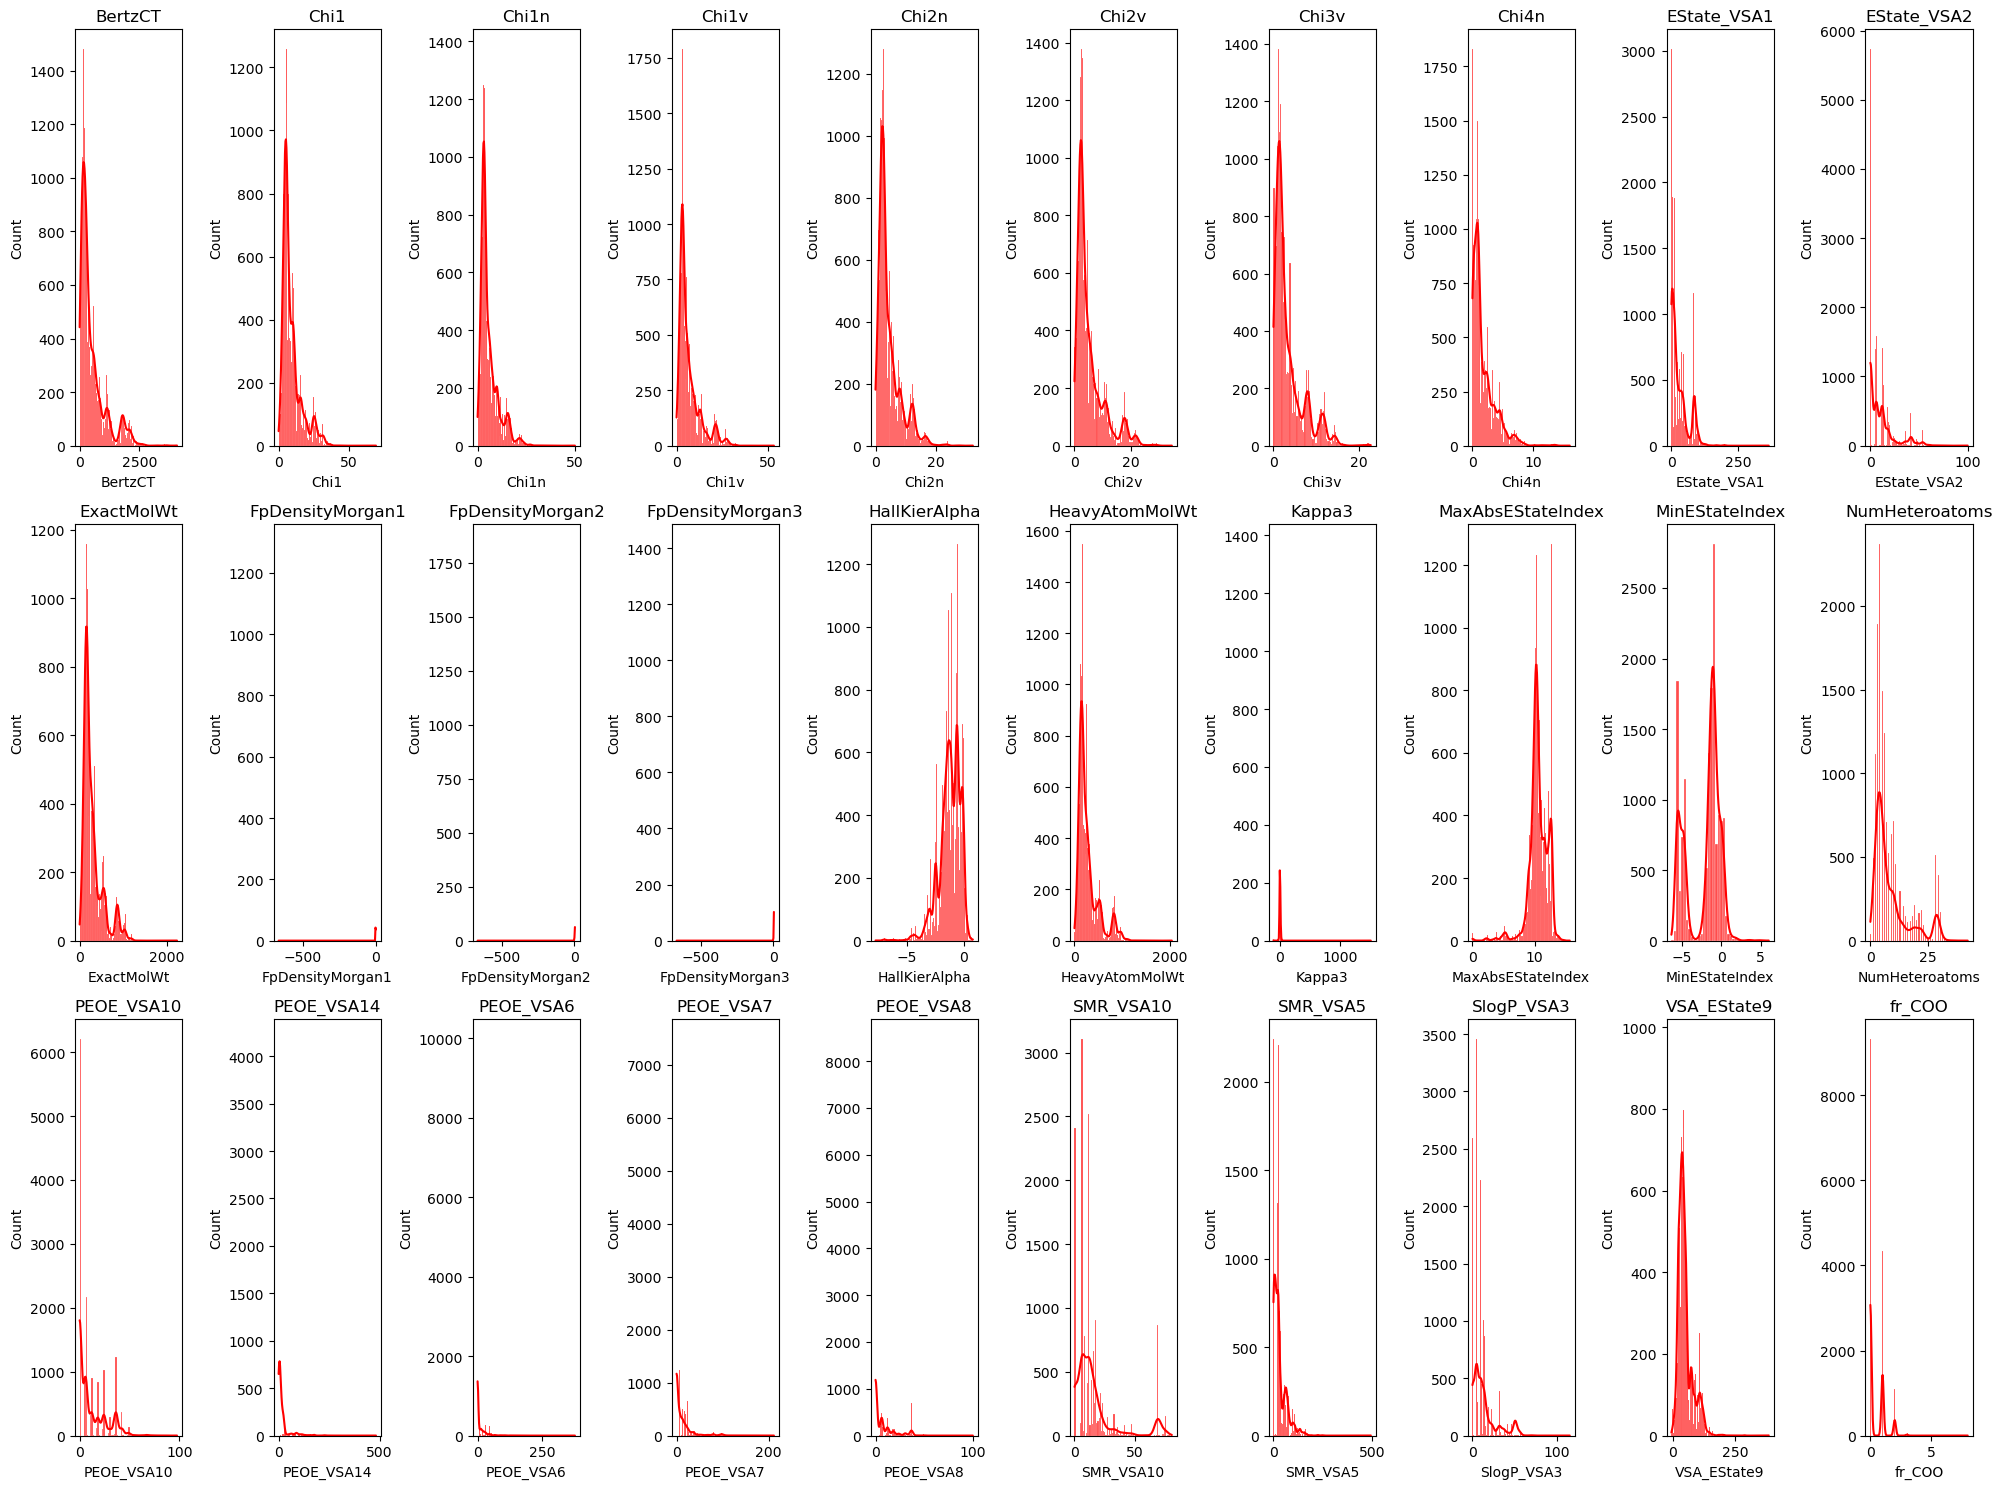

In [51]:
## Data distribution

names = X.columns

fig, ax = plt.subplots(3, 10, figsize=(20,15))

for plots, col in zip(ax.flatten(), names):
    sns.set_style('whitegrid')
    sns.histplot(data=X[col], label=col, alpha=0.7, color='red', kde=True, ax=plots)
    plots.set_title(col)
plt.tight_layout()
plt.show()
    

<Figure size 640x480 with 0 Axes>

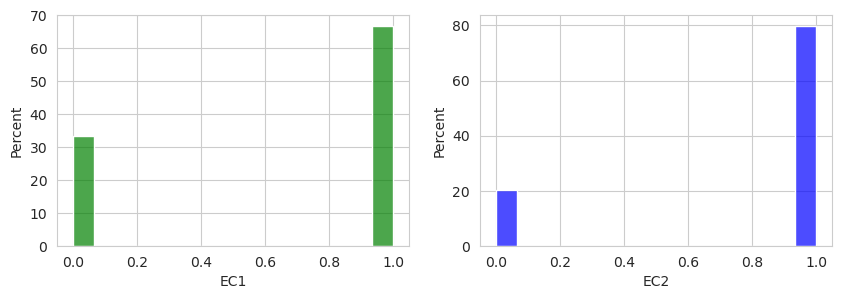

<Figure size 640x480 with 0 Axes>

In [52]:
## Validate Class imbalances.

fig, ax = plt.subplots(1,2, figsize=(10,3))
sns.set_style('whitegrid')
sns.histplot(data=y1,  label='EC1', alpha=0.7, color='green', stat='percent', ax=ax[0])
sns.histplot(data=y2,  label='EC2', alpha=0.7, color='blue', stat='percent', ax= ax[1])
ax[0].set_xlabel('EC1')
ax[1].set_xlabel('EC2')
# plt.legend()
plt.figure()

In [53]:
print('EC1 -->')
print(y1.value_counts())
print('EC2 -->')
print(y2.value_counts())

EC1 -->
1    9908
0    4930
Name: EC1, dtype: int64
EC2 -->
1    11855
0     2983
Name: EC2, dtype: int64


# Feature Analysis

***a. Correlation Matrix and Dendograms***<br>
We use dendograms to identify features that are similar and correlation matrix to check their relationships. Based on features with 0.90 positive correlation and same group in dendogram, we eliminate them. Thus, the columns - 'Chi4n', 'FpDensityMorgan2', 'FpDensityMorgan3', 'HeavyAtomMolWt', 'fr_COO2' - are eliminated. 

***b. Feature Importance Scores***<br>
According to feature importance 'fr_COO' has the least importance for original, undersampled and oversampled data. Therefore we eliminate it.

***c. PCA Variance Ratios***<br>
6 PCs are needed to represent the data.




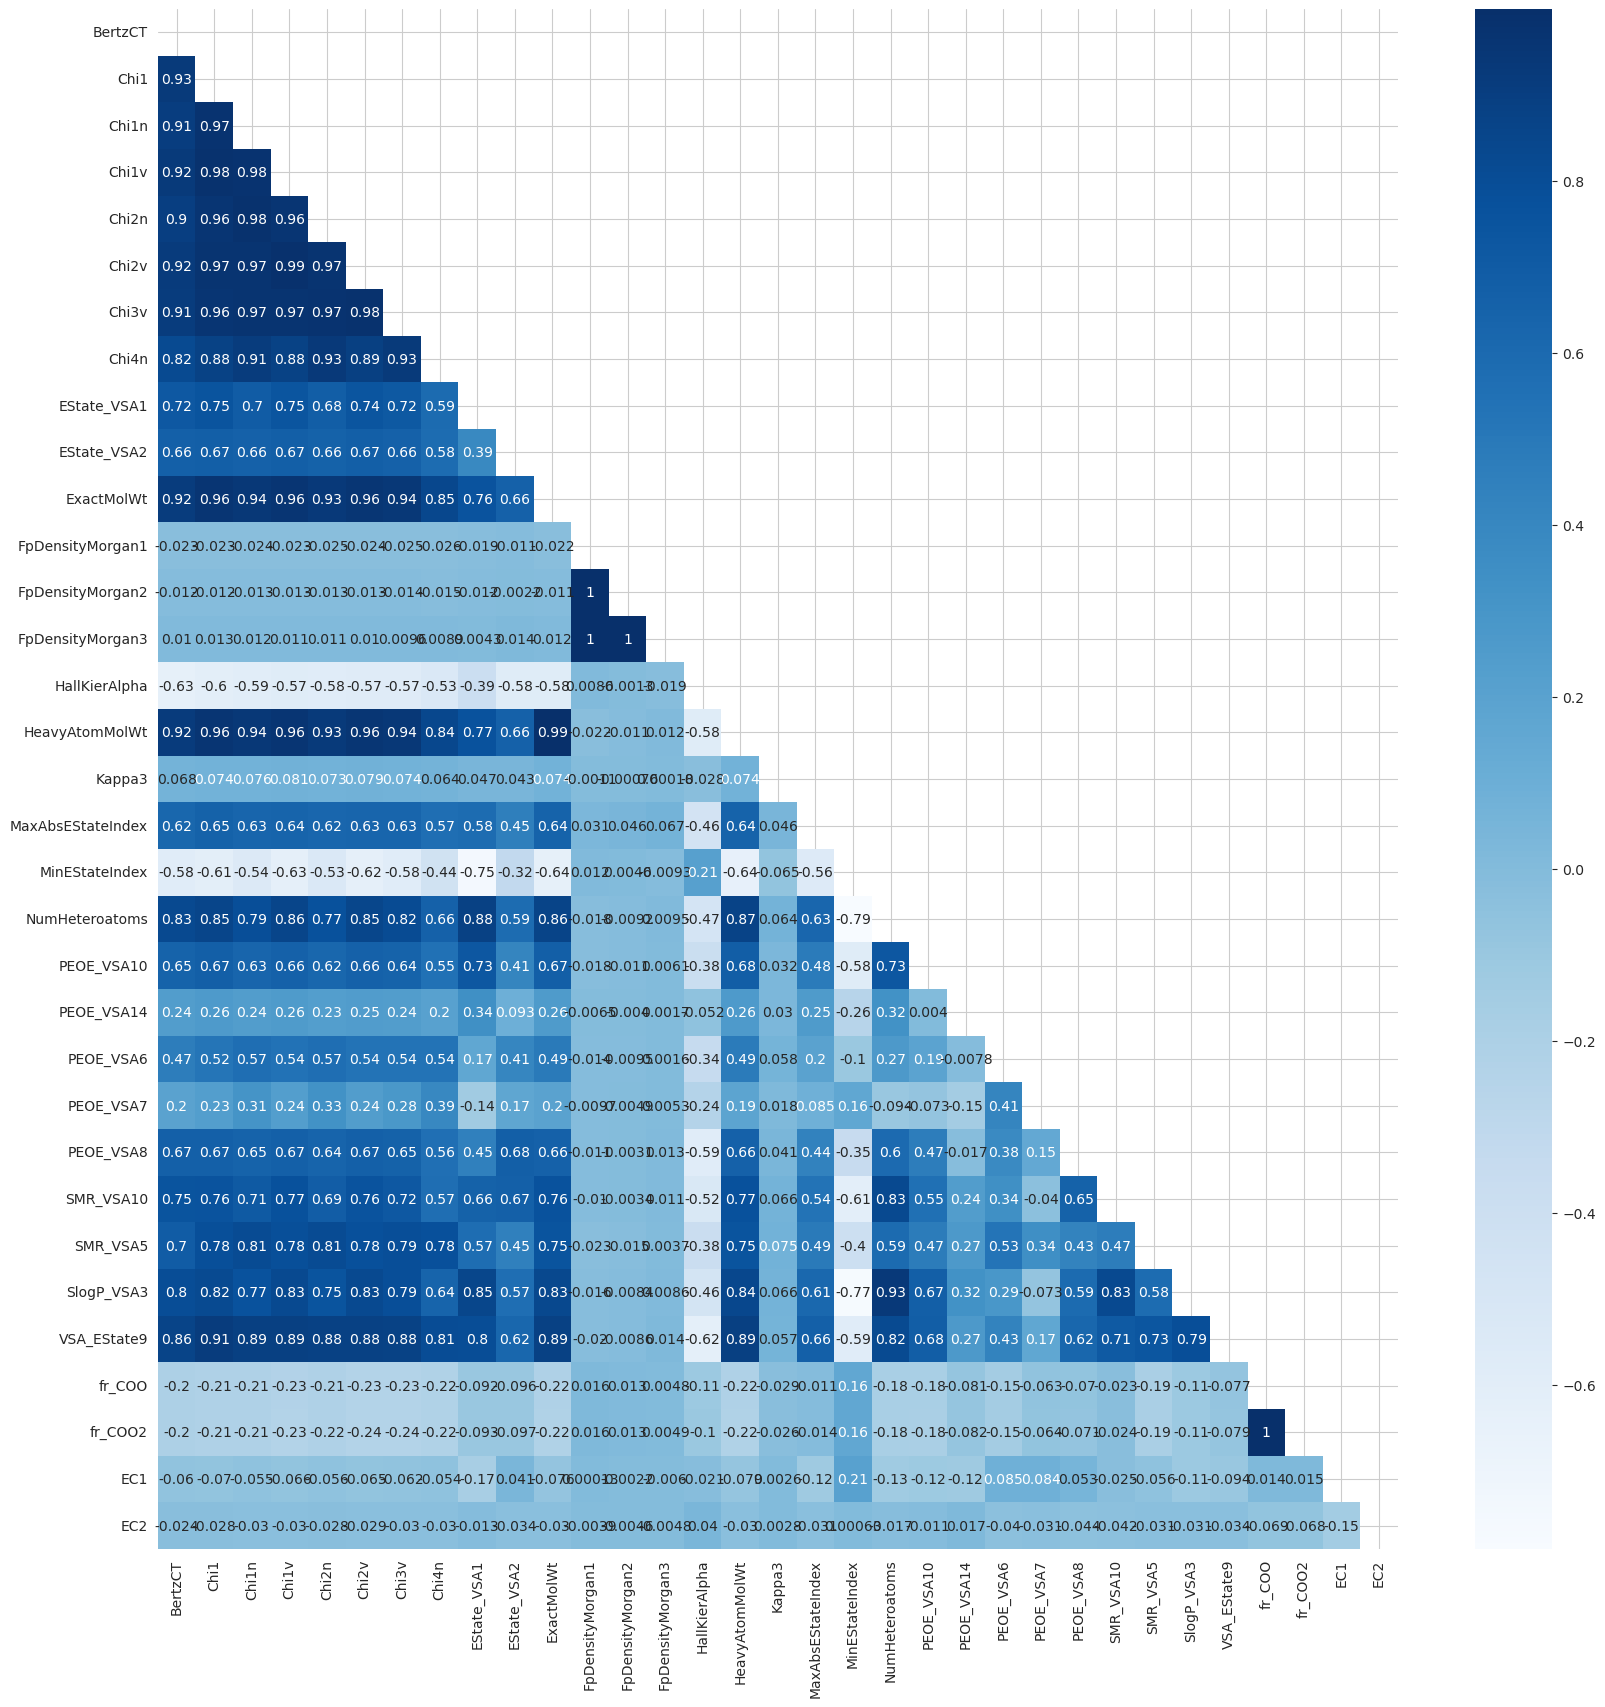

In [54]:
## Correlation Matrix
corr = raw1.corr()
mask = np.triu(corr)

plt.figure(figsize=(20,20))
sns.heatmap(corr, mask=mask, annot=True, cmap='Blues')
plt.show()

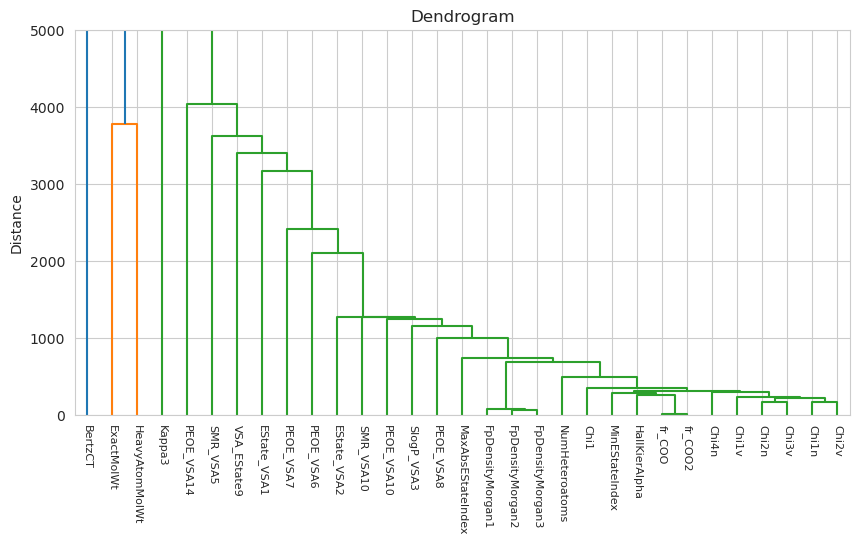

In [55]:
distance_matrix = hierarchy.distance.pdist(X.T)
linkage_matrix = hierarchy.linkage(distance_matrix, method='single')

plt.figure(figsize=(10, 5))
dendrogram = hierarchy.dendrogram(linkage_matrix, labels=X.T.index)
# plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.title('Dendrogram')
plt.xticks(rotation=270)
plt.ylim(0,5000)
plt.show()


In [59]:
# Standardization

sc = StandardScaler()
X_std = sc.fit_transform(X)

In [61]:
## Feature Importance EC1

estimator1 = RandomForestClassifier(n_estimators=100,criterion="gini", random_state=123)
estimator1.fit(X_std, y1)

## RFE
rfe1 = RFE(estimator1, n_features_to_select=10)
rfe1.fit(X,y1)

RFE(estimator=RandomForestClassifier(random_state=123), n_features_to_select=10)

In [62]:
## Feature Importance EC2

estimator2 = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=123)
estimator2.fit(X, y2)

## RFE
rfe2 = RFE(estimator2, n_features_to_select=10)
rfe2.fit(X,y2)

RFE(estimator=RandomForestClassifier(random_state=123), n_features_to_select=10)

In [63]:
## Feature Importance EC1

names = X.columns
importance1 = estimator1.feature_importances_
ranking1 = rfe1.ranking_
variances = [np.var(X[col]) for col in names]

features_df1 = pd.DataFrame([names, importance1, ranking1, variances], index=['Name', 'Score', 'Rank', 'Variance']).T.\
set_index('Name').sort_values(by='Score', ascending=False)
features_df1

,Score,Rank,Variance
Name,,,
MinEStateIndex,0.04993,1,4.269782
EState_VSA1,0.044116,1,1006.641256
MaxAbsEStateIndex,0.042432,1,2.431349
Chi2v,0.040559,1,24.254629
NumHeteroatoms,0.04014,6,58.423274
Kappa3,0.039844,1,2091.112675
Chi1v,0.039664,1,34.412846
VSA_EState9,0.03907,1,851.113017
BertzCT,0.038654,1,294239.082323


In [64]:
names = X.columns
importance2 = estimator2.feature_importances_
ranking2 = rfe2.ranking_
variances = [np.var(X[col]) for col in names]

features_df2 = pd.DataFrame([names, importance2, ranking2, variances], index=['Name', 'Score', 'Rank', 'Variance']).T.\
set_index('Name').sort_values(by='Score', ascending=False)
features_df2

,Score,Rank,Variance
Name,,,
MinEStateIndex,0.045546,1,4.269782
MaxAbsEStateIndex,0.045383,1,2.431349
VSA_EState9,0.045041,1,851.113017
BertzCT,0.044345,1,294239.082323
Kappa3,0.04318,1,2091.112675
Chi4n,0.042984,1,3.48134
Chi3v,0.04216,1,11.806732
Chi2n,0.041746,3,14.14053
Chi2v,0.041025,1,24.254629


In [65]:
sc = StandardScaler()
X_std = sc.fit_transform(X)

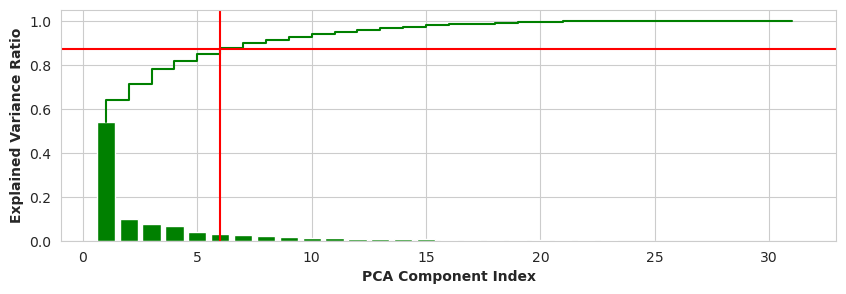

In [66]:
## PCA explained variance analysis

pca1 = PCA()
pca1.fit_transform(X_std)

plt.figure(figsize=(10,3))
plt.bar(x=range(1,len(pca1.explained_variance_ratio_)+1), height=pca1.explained_variance_ratio_, color="green")
plt.step(x=range(1,len(pca1.explained_variance_ratio_)+1),y=np.cumsum(pca1.explained_variance_ratio_), color="green")
plt.axhline(y=0.87, color="red")
plt.axvline(x=6, color="red")
plt.xlabel('PCA Component Index', fontweight="bold")
plt.ylabel('Explained Variance Ratio', fontweight="bold")
plt.show()

In [67]:
# Get the PCA loadings
loadings = pca1.components_.T
names = X.columns

fig = go.Figure()
for i,name in zip(range(loadings.shape[1]), names):
    fig.add_trace(go.Scatter3d(
        x=[0, loadings[0, i]],
        y=[0, loadings[1, i]],
        z=[0, loadings[2, i]],
        mode='lines+markers',
        name=f'{name}',
        marker=dict(size=4),
        line=dict(color='red', width=2),
        text=f'{name}'
    ))

fig.update_layout(
    title='PCA Loadings Plot',
    scene=dict(
        xaxis=dict(title='PC1'),
        yaxis=dict(title='PC2'),
        zaxis=dict(title='PC3')
    ),
    showlegend=True
)

fig.show()


In [24]:
## Selective Columns

X11 = X.loc[:,['MinEStateIndex','MaxAbsEStateIndex','ExactMolWt','EState_VSA1','NumHeteroatoms','Kappa3','Chi2v',\
         'Chi1v','VSA_EState9','BertzCT','FpDensityMorgan1']]
X12 = X.loc[:,['MinEStateIndex','MaxAbsEStateIndex','VSA_EState9','BertzCT','Kappa3','Chi4n','FpDensityMorgan3']]

raw_test1 = raw_test.loc[:,['MinEStateIndex','MaxAbsEStateIndex','ExactMolWt','EState_VSA1','NumHeteroatoms','Kappa3','Chi2v',\
         'Chi1v','VSA_EState9','BertzCT','FpDensityMorgan1']]
raw_test2 = raw_test.loc[:,['MinEStateIndex','MaxAbsEStateIndex','VSA_EState9','BertzCT','Kappa3','Chi4n','FpDensityMorgan3']]

# raw_test2 = raw_test.drop(['Chi4n', 'FpDensityMorgan2', 'FpDensityMorgan3', 'HeavyAtomMolWt', 'fr_COO2'], axis=1)

# Model Selection (#3)

In [25]:
oversampler = RandomOverSampler(random_state=42)
undersampler = RandomUnderSampler(random_state=42)

In [26]:
X_over1, y_over1 = oversampler.fit_resample(X11, y1)
X_under1, y_under1 = undersampler.fit_resample(X11, y1)
print(y_over1.value_counts())
print(y_under1.value_counts())
print(X_over1.shape)

1    9908
0    9908
Name: EC1, dtype: int64
0    4930
1    4930
Name: EC1, dtype: int64
(19816, 11)


In [27]:
X_over2, y_over2 = oversampler.fit_resample(X12, y2)
X_under2, y_under2 = undersampler.fit_resample(X12, y2)
print(y_over2.value_counts())
print(y_under2.value_counts())
print(X_over2.shape)

1    11855
0    11855
Name: EC2, dtype: int64
0    2983
1    2983
Name: EC2, dtype: int64
(23710, 7)


In [28]:
def pipes(learner):
    
    match learner:
        
        case "Logistic":
            pipe = Pipeline([('sc', StandardScaler()),
                            ('pca', PCA(random_state=123)),
#                             ('lda',LinearDiscriminantAnalysis()),
                            ('lr', LogisticRegression())
                            ])
        case "Ridge":
            pipe = Pipeline([('sc', StandardScaler()),
                             ('pca', PCA(random_state=123)),
#                              ('lda',LinearDiscriminantAnalysis()),
                             ('rig', RidgeClassifier(random_state=123))
                            ])
        case "SVC":
            pipe =  Pipeline([('sc', StandardScaler()),
                             ('pca', PCA(random_state=123)),
#                              ('lda',LinearDiscriminantAnalysis()),
                             ('svc', SVC(random_state=123))
                            ])
            
        case "RandomForest":
            pipe =  Pipeline([('sc', StandardScaler()),
                              ('pca', PCA(random_state=123)),
#                              ('lda',LinearDiscriminantAnalysis()),
                             ('rf', RandomForestClassifier(random_state=123, n_jobs=-1))
                            ])
    return pipe
    

def params(learner):
    
    match learner:
        
        case "Logistic":
            
            params = dict(pca__n_components= [6],
                              lr__C= uniform(loc=0, scale=4),
                              lr__penalty= ['l2'],
                              lr__max_iter= range(50,200),
                              lr__solver= ['lbfgs']
                             )
        
        case 'Ridge':
            params =  dict(pca__n_components= [6],
                               rig__alpha= uniform(loc=0, scale=4),
                               rig__solver= ['saga', 'svd']
                              )
    
        case 'SVC':
            params = dict(pca__n_components=[6],
                              svc__C=uniform(loc=0, scale=4),
                              svc__tol=[0.0001],
                              svc__kernel=['rbf'],
                              svc__gamma=uniform(loc=0, scale=4)
                             )
            
        case 'RandomForest':
            params = dict(pca__n_components=[6],
                            rf__n_estimators=range(30,101),
                              rf__max_depth=range(4,21))
            
    return params

In [29]:
def best_scores(X_train, y_train, X_test, y_test):
    model_list = ["Logistic", "Ridge", "SVC", "RandomForest"]
    
    for mod in model_list:
        grid = RandomizedSearchCV(pipes(mod),params(mod),n_jobs=-1, cv=5, refit=True)
        grid.fit(X_train, y_train)
        y_pred = grid.predict(X_test)
        print(f'{mod} -->\t\t Accuracy:{grid.best_score_}\t F1: {f1_score(y_test, y_pred)}\t Precision: {precision_score(y_test, y_pred)}')

In [30]:
## EC1
for (X, y, name) in [(X11, y1, "Original"), (X_under1, y_under1, "UnderSampling"), (X_over1, y_over1, "OverSampling")]:
    print(f'\n{name}-->')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=123)
    best_scores(X_train, y_train, X_test, y_test)


Original-->
Logistic -->		 Accuracy:0.6704296545914069	 F1: 0.7962369039982895	 Precision: 0.6909090909090909
Ridge -->		 Accuracy:0.6656276326874473	 F1: 0.7933291112518471	 Precision: 0.682032667876588
SVC -->		 Accuracy:0.7008424599831508	 F1: 0.7953772943575798	 Precision: 0.7219251336898396
RandomForest -->		 Accuracy:0.6971356360572872	 F1: 0.7942714253239372	 Precision: 0.7227968556061233

UnderSampling-->
Logistic -->		 Accuracy:0.6208161844898104	 F1: 0.6287952987267384	 Precision: 0.6079545454545454
Ridge -->		 Accuracy:0.6200554067380186	 F1: 0.6254295532646047	 Precision: 0.6060894386298763
SVC -->		 Accuracy:0.6531458634216675	 F1: 0.6594167078596144	 Precision: 0.6432015429122468
RandomForest -->		 Accuracy:0.6539066411734591	 F1: 0.6614017769002961	 Precision: 0.6442307692307693

OverSampling-->
Logistic -->		 Accuracy:0.6230761226294683	 F1: 0.6334381804984274	 Precision: 0.6085541608554161
Ridge -->		 Accuracy:0.621499173802013	 F1: 0.6323671497584541	 Precision: 0.60

In [31]:
## EC2
for (X, y, name) in [(X12, y2, "Original"), (X_under2, y_under2, "UnderSampling"), (X_over2, y_over2, "OverSampling")]:
    print(f'\n{name}-->')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=123)
    best_scores(X_train, y_train, X_test, y_test)


Original-->
Logistic -->		 Accuracy:0.798989048020219	 F1: 0.888181307360929	 Precision: 0.7988544474393531
Ridge -->		 Accuracy:0.798989048020219	 F1: 0.888181307360929	 Precision: 0.7988544474393531
SVC -->		 Accuracy:0.798989048020219	 F1: 0.888181307360929	 Precision: 0.7988544474393531
RandomForest -->		 Accuracy:0.798989048020219	 F1: 0.888181307360929	 Precision: 0.7988544474393531

UnderSampling-->
Logistic -->		 Accuracy:0.5123672165695282	 F1: 0.5270935960591133	 Precision: 0.5169082125603864
Ridge -->		 Accuracy:0.5125766406532979	 F1: 0.5295081967213116	 Precision: 0.5184590690208668
SVC -->		 Accuracy:0.5471572985610326	 F1: 0.497196261682243	 Precision: 0.5623678646934461
RandomForest -->		 Accuracy:0.5400296354835523	 F1: 0.49619771863117873	 Precision: 0.5736263736263736

OverSampling-->
Logistic -->		 Accuracy:0.5130750386257958	 F1: 0.5351427992708123	 Precision: 0.5148090413094311
Ridge -->		 Accuracy:0.5129168663913675	 F1: 0.5354394491697043	 Precision: 0.51499805

In [68]:
ada_pipe = Pipeline([('sc', StandardScaler()),
#                      ('rfe', RFE(estimator=RandomForestClassifier(n_estimators=57, random_state=123, n_jobs=-1))),
#                       ('pca', PCA(random_state=123)),
#                              ('lda',LinearDiscriminantAnalysis()),
                     ('ada', AdaBoostClassifier(random_state=123))
                    ])

ada_pipe.get_params()

ada_params = dict(#rfe__n_features_to_select=range(4,12),
                  ada__learning_rate=uniform(loc=0, scale=1),
                  ada__n_estimators=range(5,20)
                 )

ada_grid = RandomizedSearchCV(ada_pipe,ada_params,n_jobs=-1, cv=5, refit=True)

for (X, y, name) in [(X11, y1, "Original"), (X_under1, y_under1, "UnderSampling"), (X_over1, y_over1, "OverSampling")]:
    print(f'\n{name}-->')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=123)
    ada_grid.fit(X_train, y_train)
    print(ada_grid.best_score_)
    print(ada_grid.best_params_)
                


Original-->
0.6975568660488627
{'ada__learning_rate': 0.5137708493428362, 'ada__n_estimators': 13}

UnderSampling-->
0.6568236524243865
{'ada__learning_rate': 0.9774113290926456, 'ada__n_estimators': 7}

OverSampling-->
0.6571408675029125
{'ada__learning_rate': 0.5045322858273592, 'ada__n_estimators': 19}


In [69]:
for (X, y, name) in [(X12, y2, "Original"), (X_under2, y_under2, "UnderSampling"), (X_over2, y_over2, "OverSampling")]:
    print(f'\n{name}-->')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=123)
    ada_grid.fit(X_train, y_train)
    print(ada_grid.best_score_)
    print(ada_grid.best_params_)


Original-->
0.798989048020219
{'ada__learning_rate': 0.9168701678102923, 'ada__n_estimators': 5}

UnderSampling-->
0.5496646799916581
{'ada__learning_rate': 0.28733458646670096, 'ada__n_estimators': 19}

OverSampling-->
0.5590463441450354
{'ada__learning_rate': 0.6138791036929024, 'ada__n_estimators': 16}


In [34]:
grad_pipe = Pipeline([('sc', StandardScaler()),
#                      ('rfe', RFE(estimator=RandomForestClassifier(n_estimators=57, random_state=123, n_jobs=-1))),
#                       ('pca', PCA(random_state=123)),
#                              ('lda',LinearDiscriminantAnalysis()),
                     ('grad', GradientBoostingClassifier(random_state=123))
                    ])

grad_params =dict(grad__loss=['log_loss', 'exponential'],
                     grad__n_estimators=range(10,100),
                     grad__max_depth=range(5,20),
                     grad__learning_rate=uniform(loc=0, scale=1)
                     )

grad_grid = RandomizedSearchCV(grad_pipe,grad_params,n_jobs=-1, cv=5, refit=True)


## EC1
for (X, y, name) in [(X11, y1, "Original"), (X_under1, y_under1, "UnderSampling"), (X_over1, y_over1, "OverSampling")]:
    print(f'\n{name}-->')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=123)
    grad_grid.fit(X_train, y_train)
    print(grad_grid.best_score_)
    print(grad_grid.best_params_)
                


Original-->
0.6823925863521481
{'grad__learning_rate': 0.6181141041464306, 'grad__loss': 'exponential', 'grad__max_depth': 15, 'grad__n_estimators': 92}

UnderSampling-->
0.6389477059729815
{'grad__learning_rate': 0.3072372561070713, 'grad__loss': 'log_loss', 'grad__max_depth': 6, 'grad__n_estimators': 11}

OverSampling-->
0.7824880845437805
{'grad__learning_rate': 0.8610320558316087, 'grad__loss': 'exponential', 'grad__max_depth': 11, 'grad__n_estimators': 97}


In [35]:
##EC2
for (X, y, name) in [(X12, y2, "Original"), (X_under2, y_under2, "UnderSampling"), (X_over2, y_over2, "OverSampling")]:
    print(f'\n{name}-->')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=123)
    grad_grid.fit(X_train, y_train)
    print(grad_grid.best_score_)
    print(grad_grid.best_params_)


Original-->
0.7927548441449032
{'grad__learning_rate': 0.09157255149956367, 'grad__loss': 'exponential', 'grad__max_depth': 11, 'grad__n_estimators': 87}

UnderSampling-->
0.534369477647162
{'grad__learning_rate': 0.14115664751231471, 'grad__loss': 'log_loss', 'grad__max_depth': 11, 'grad__n_estimators': 13}

OverSampling-->
0.9281421079059573
{'grad__learning_rate': 0.5166403138224346, 'grad__loss': 'log_loss', 'grad__max_depth': 19, 'grad__n_estimators': 99}


# Best Model Analysis

In [94]:
# EC1 Model

X_train, X_test, y_train, y_test = train_test_split(X_over1, y_over1, test_size=0.2, stratify=y_over1, shuffle=True, random_state=123)

ec1_params = dict(rf__n_estimators=range(30,101),
                  rf__max_depth=range(4,21))

ec1_pipe =  Pipeline([('sc', StandardScaler()),
                      (('pca', PCA(n_components =6, random_state=123))),
                      ('rf', RandomForestClassifier(random_state=123, n_jobs=-1))
                      ])

# ec1_params = dict(grad__loss=['log_loss', 'exponential'],
#                      grad__n_estimators=range(10,100),
#                      grad__max_depth=range(5,20),
#                      grad__learning_rate=uniform(loc=0, scale=1)
#                      )

# ec1_pipe =  Pipeline([('sc', StandardScaler()),
# #                      ('rfe', RFE(estimator=RandomForestClassifier(n_estimators=57, random_state=123, n_jobs=-1))),
#                       ('pca', PCA(n_components=6, random_state=123)),
# #                       ('lda',LinearDiscriminantAnalysis()),
#                      ('grad', GradientBoostingClassifier(random_state=123))
#                     ])

ec1_grid = RandomizedSearchCV(ec1_pipe,ec1_params,n_jobs=-1, cv=5, return_train_score=True, refit=True)
ec1_grid.fit(X_train, y_train)
print(ec1_grid.best_params_)
print(ec1_grid.best_score_)

{'rf__n_estimators': 74, 'rf__max_depth': 19}
0.7778829435131271


In [95]:
ec1_results = pd.DataFrame(ec1_grid.cv_results_)
ec1_results
results1 = ec1_results[["rank_test_score","mean_train_score", "std_train_score",\
                        "mean_test_score", "std_test_score", "params"\
                       ]].sort_values(by="rank_test_score")
results1

,rank_test_score,mean_train_score,std_train_score,mean_test_score,std_test_score,params
6,1,0.987084,0.001731,0.777883,0.005199,"{'rf__n_estimators': 74, 'rf__max_depth': 19}"
9,2,0.986327,0.001925,0.776684,0.006259,"{'rf__n_estimators': 68, 'rf__max_depth': 19}"
7,3,0.953460,0.004264,0.757129,0.002758,"{'rf__n_estimators': 52, 'rf__max_depth': 16}"
2,4,0.953397,0.004649,0.756750,0.004982,"{'rf__n_estimators': 54, 'rf__max_depth': 16}"
0,5,0.886355,0.003116,0.731643,0.005477,"{'rf__n_estimators': 95, 'rf__max_depth': 13}"
5,6,0.822783,0.003294,0.710447,0.005071,"{'rf__n_estimators': 72, 'rf__max_depth': 11}"
1,7,0.754148,0.003230,0.684898,0.005680,"{'rf__n_estimators': 88, 'rf__max_depth': 9}"
8,8,0.669269,0.001795,0.656700,0.005551,"{'rf__n_estimators': 90, 'rf__max_depth': 5}"
3,9,0.658261,0.001492,0.651464,0.006013,"{'rf__n_estimators': 44, 'rf__max_depth': 4}"
4,10,0.659302,0.001812,0.651401,0.006162,"{'rf__n_estimators': 35, 'rf__max_depth': 4}"


In [106]:
ec1_pipe =  Pipeline([('sc', StandardScaler()),
                      (('pca', PCA(n_components =6, random_state=123))),
                      ('rf', RandomForestClassifier(n_estimators=74,
                                                    max_depth=25,
                                                    random_state=123, n_jobs=-1))
                      ])

ec1_pipe.fit(X_train, y_train)

Pipeline(steps=[('sc', StandardScaler()),
                ('pca', PCA(n_components=6, random_state=123)),
                ('rf',
                 RandomForestClassifier(max_depth=25, n_estimators=74,
                                        n_jobs=-1, random_state=123))])

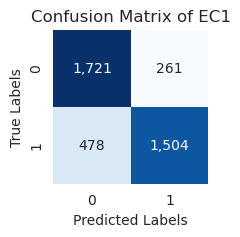

In [107]:
y_pred = ec1_pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(2, 2))
sns.heatmap(cm, annot=True, cmap="Blues", fmt=',d', cbar=False)
plt.title("Confusion Matrix of EC1")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

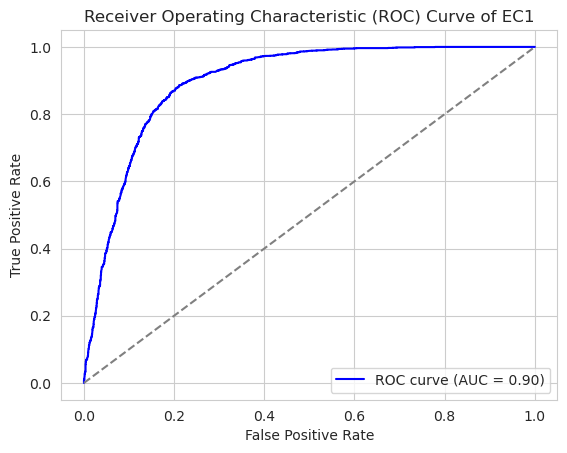

In [108]:
y_scores = ec1_pipe.predict_proba(X_test)
# y_scores
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of EC1')
plt.legend(loc='lower right')
plt.show()

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X_over2, y_over2, test_size=0.2, stratify=y_over2, shuffle=True, random_state=123)


# ec2_params = dict(rf__n_estimators=range(30,101),
#                   rf__max_depth=range(4,21))

# ec2_pipe =  Pipeline([('sc', StandardScaler()),
#                       ('rf', RandomForestClassifier(random_state=123, n_jobs=-1))
#                       ])

ec2_params = dict(grad__loss=['log_loss', 'exponential'],
                     grad__n_estimators=range(10,100),
                     grad__max_depth=range(5,20),
                     grad__learning_rate=uniform(loc=0, scale=1)
                     )

ec2_pipe =  Pipeline([('sc', StandardScaler()),
#                      ('rfe', RFE(estimator=RandomForestClassifier(n_estimators=57, random_state=123, n_jobs=-1))),
                      ('pca', PCA(n_components=6,random_state=123)),
#                       ('lda',LinearDiscriminantAnalysis()),
                     ('grad', GradientBoostingClassifier(random_state=123))
                    ])

ec2_grid = RandomizedSearchCV(ec2_pipe,ec2_params,n_jobs=-1, cv=5, return_train_score=True, refit=True)
ec2_grid.fit(X_train, y_train)
print(ec2_grid.best_params_)
print(ec2_grid.best_score_)

{'grad__learning_rate': 0.2506630307591462, 'grad__loss': 'exponential', 'grad__max_depth': 18, 'grad__n_estimators': 44}
0.8941900576777602


In [114]:
ec2_results = pd.DataFrame(ec2_grid.cv_results_)
ec2_results
results2 = ec2_results[["rank_test_score","mean_train_score", "std_train_score",\
                        "mean_test_score", "std_test_score", "params"\
                       ]].sort_values(by="rank_test_score")
results2.iloc

,rank_test_score,mean_train_score,std_train_score,mean_test_score,std_test_score,params
1,1,0.997430,0.000172,0.894190,0.010223,"{'grad__learning_rate': 0.2506630307591462, 'g..."
6,2,0.997259,0.000189,0.889709,0.005718,"{'grad__learning_rate': 0.1384051573209082, 'g..."
8,3,0.993120,0.001604,0.870149,0.006279,"{'grad__learning_rate': 0.09368638769527204, '..."
2,4,0.994253,0.001179,0.863771,0.004159,"{'grad__learning_rate': 0.4656663543049696, 'g..."
0,5,0.996995,0.000330,0.863717,0.003976,"{'grad__learning_rate': 0.6923799741266762, 'g..."
4,6,0.967709,0.004871,0.831716,0.008840,"{'grad__learning_rate': 0.22060419507240336, '..."
7,7,0.928050,0.011672,0.801401,0.013810,"{'grad__learning_rate': 0.04913263684068159, '..."
5,8,0.938647,0.014920,0.799558,0.008424,"{'grad__learning_rate': 0.5639245161835044, 'g..."
3,9,0.902388,0.010664,0.767291,0.012252,"{'grad__learning_rate': 0.6789079873057607, 'g..."
9,10,0.656698,0.004968,0.610766,0.006812,"{'grad__learning_rate': 0.015152283002686229, ..."


In [132]:
ec2_pipe =  Pipeline([('sc', StandardScaler()),
                      ('pca', PCA(n_components=6,random_state=123)),
                      ('grad', GradientBoostingClassifier(learning_rate= 0.25066,
                                                          loss= 'exponential',
                                                          max_depth= 18,
                                                          n_estimators= 40,
                                                          validation_fraction=0.1,
                                                          random_state=123))
                    ])

ec2_pipe.fit(X_train, y_train)

Pipeline(steps=[('sc', StandardScaler()),
                ('pca', PCA(n_components=6, random_state=123)),
                ('grad',
                 GradientBoostingClassifier(learning_rate=0.25066,
                                            loss='exponential', max_depth=18,
                                            n_estimators=40,
                                            random_state=123))])

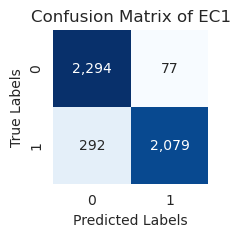

In [133]:
y_pred = ec2_pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(2, 2))
sns.heatmap(cm, annot=True, cmap="Blues", fmt=',d', cbar=False)
plt.title("Confusion Matrix of EC1")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

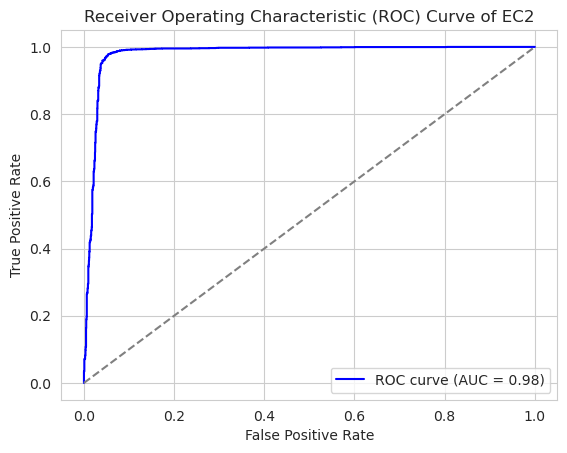

In [134]:
y_scores = ec2_grid.predict_proba(X_test)
# y_scores
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of EC2')
plt.legend(loc='lower right')
plt.show()

# Final Submission

In [42]:
ec1_pipe.fit(X_over1, y_over1)
ec2_pipe.fit(X_over2, y_over2)

Pipeline(steps=[('sc', StandardScaler()),
                ('pca', PCA(n_components=6, random_state=123)),
                ('grad', GradientBoostingClassifier(random_state=123))])

In [43]:
y_pred1 = ec1_pipe.predict(raw_test1)
y_pred2 = ec2_pipe.predict(raw_test2)

In [44]:
submission = pd.read_csv('/kaggle/input/playground-series-s3e18/sample_submission.csv')
submission['id'] = raw_test1.index
submission['EC1'] = y_pred1
submission['EC2'] = y_pred2

In [45]:
submission.to_csv('submission.csv', index=False)